In [1]:
import pymc3 as pm
import theano.tensor as T
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

In [2]:
with pm.Model() as model:
    lambda_ = pm.Exponential('poisson_param', 1)
    data_generator = pm.Poisson('data_generator', lambda_)
    data_plus_one = data_generator + 1

In [3]:
with model:
    lambda_1 = pm.Exponential('lambda_1', 1)
    lambda_2 = pm.Exponential('lambda_2', 1)
    tau = pm.DiscreteUniform('tau', lower=0, upper=10)

(0, 8)

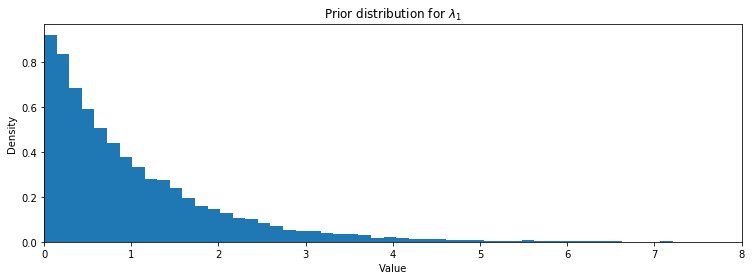

In [4]:
figsize(12.5, 4)
samples = [lambda_1.random() for i in range(20000)]
plt.hist(samples, bins=70, normed=True, histtype='stepfilled')
plt.title('Prior distribution for $\lambda_1$')
plt.xlabel('Value')
plt.ylabel('Density')
plt.xlim(0, 8)

In [5]:
tau = np.random.randint(0, 80)
print(tau)

25


In [6]:
alpha = 1. / 20.
lambda_1, lambda_2 = np.random.exponential(scale=1./alpha, size=2)
print(lambda_1, lambda_2)

65.4544850996 14.273939818


In [7]:
import scipy.stats as stats
data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size = 80 - tau)]

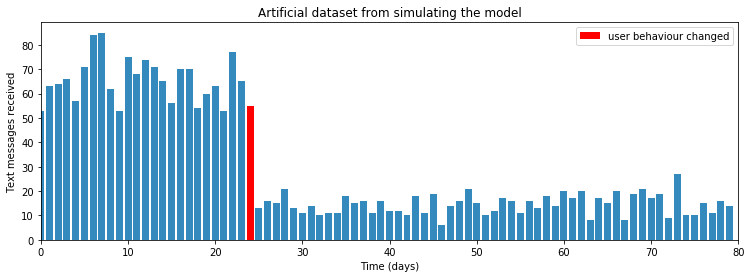

In [8]:
plt.bar(np.arange(80), data, color='#348ABD')
plt.bar(tau - 1, data[tau - 1], color='r', label='user behaviour changed')
plt.xlabel('Time (days)')
plt.ylabel('Text messages received')
plt.title('Artificial dataset from simulating the model')
plt.xlim(0, 80)
plt.legend()

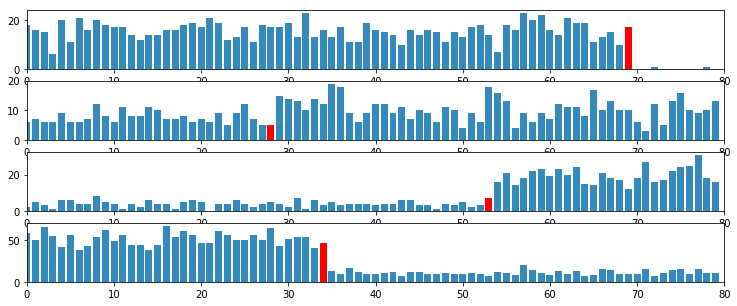

In [9]:
def plot_artificial_sms_dataset():
    tau = stats.randint.rvs(0, 80)
    alpha = 1. / 20.
    lambda_1, lambda_2 = stats.expon.rvs(scale=1./alpha, size=2)
    data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size=80 - tau)]
    plt.bar(np.arange(80), data, color="#348ABD")
    plt.bar(tau - 1, data[tau-1], color="r", label="user behaviour changed")
    plt.xlim(0, 80);

figsize(12.5, 5)
plt.title("More example of artificial datasets")
for i in range(4):
    plt.subplot(4, 1, i+1)
    plot_artificial_sms_dataset()

In [11]:
with pm.Model()as model:
    p = pm.Uniform('p', lower=0, upper=1)

In [12]:
p_true = 0.05
N = 1500

occurrences = stats.bernoulli.rvs(p_true, size=N)

print(occurrences)
print(occurrences.sum())

[0 0 0 ..., 0 0 0]
73


In [13]:
print('What is the observed frequency in Group A? {}'.format(occurrences.mean()))
print('Does the observed frequency equal the true frequency? {}'.format(occurrences.mean() == p_true))

What is the observed frequency in Group A? 0.048666666666666664
Does the observed frequency equal the true frequency? False


In [14]:
with model:
    obs = pm.Bernoulli('obs', p, observed=occurrences)
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

c:\users\owner\anaconda3\envs\py3\lib\site-packages\pymc3\sampling.py:231: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically '
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18000/18000 [00:02<00:00, 7228.00it/s]


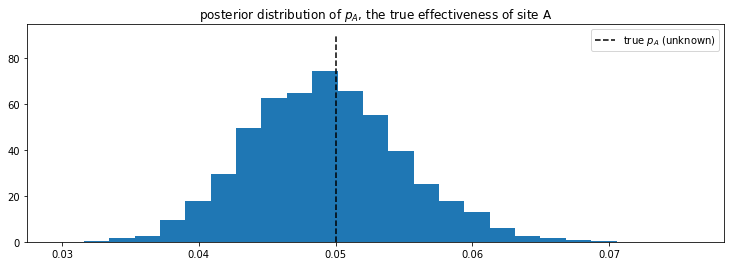

In [16]:
figsize(12.5, 4)
plt.title('posterior distribution of $p_A$, the true effectiveness of site A')
plt.vlines(p_true, 0, 90, linestyles='--', label='true $p_A$ (unknown)')
plt.hist(burned_trace['p'], bins=25, histtype='stepfilled', normed=True)
plt.legend()

## 嘘に対抗するアルゴリズム

- binomial分布

$$
X \sim Binomial(N, p)
$$

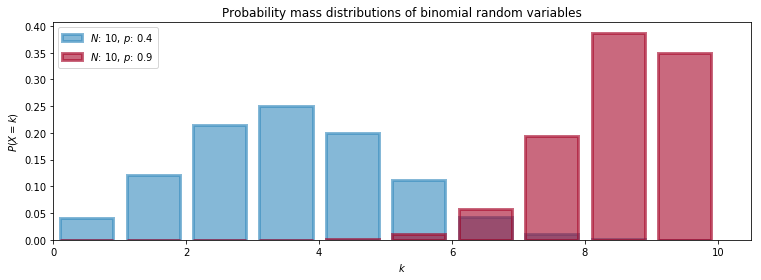

In [2]:
figsize(12.5, 4)
import scipy.stats as stats
binomial = stats.binom
parameters = [(10, .4), (10, .9)]
colors = ['#348ABD', '#A60628']

for i in range(2):
    N, p = parameters[i]
    _x = np.arange(N + 1)
    plt.bar(_x - 0.5, binomial.pmf(_x, N, p), color=colors[i],
               edgecolor=colors[i], alpha=0.6, linewidth=3,
               label='$N$: {}, $p$: {}'.format(N, p))
    plt.legend(loc='upper left')
    plt.xlim(0, 10.5)
    plt.xlabel('$k$')
    plt.ylabel('$P(X = k)$')
    plt.title('Probability mass distributions of binomial random variables')

In [17]:
N = 100
with pm.Model() as model:
    p = pm.Uniform('freq_cheating', 0, 1)

In [18]:
with model:
    true_answers = pm.Bernoulli('truths', p, shape=N, testval=np.random.binomial(1, 0.5, N))

In [19]:
with model:
    first_coin_flips = pm.Bernoulli('first_flips', 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))
print(first_coin_flips.tag.test_value)

[1 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1
 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0
 0 1 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0]


In [20]:
with model:
    second_coin_flips = pm.Bernoulli('second_flips', 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))

In [21]:
import theano.tensor as T
with model:
    val = first_coin_flips*true_answers + (1 - first_coin_flips)*second_coin_flips
    observed_proportion = pm.Deterministic('observed proportion', T.sum(val)/N)

In [22]:
print(observed_proportion.tag.test_value)

0.55


In [23]:
X = 25
with model:
    obs = pm.Binomial('obs', N, observed_proportion, observed=X)

In [24]:
with model:
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(40000, step=step)
    burned_trace = trace[15000:]

c:\users\owner\anaconda3\envs\py3\lib\site-packages\pymc3\sampling.py:231: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically '
c:\users\owner\anaconda3\envs\py3\lib\site-packages\pymc3\sampling.py:234: UserWarning: Automatic initialization is not supported for discrete variables. Ignoring init argument.
  warnings.warn('Automatic initialization is not supported '
Assigned BinaryGibbsMetropolis to truths
Assigned BinaryGibbsMetropolis to first_flips
Assigned BinaryGibbsMetropolis to second_flips
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [16:11<00:00, 41.18it/s]


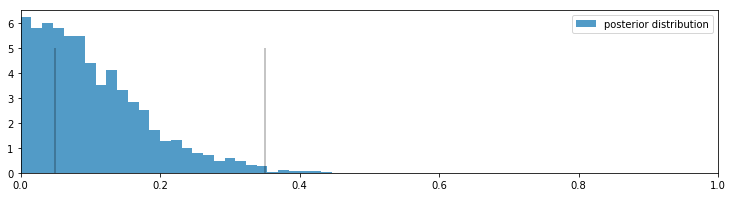

In [27]:
figsize(12.5, 3)
p_trace = burned_trace["freq_cheating"]
plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();

## チャレンジャー号の悲劇

In [28]:
from urllib.request import urlretrieve
urlretrieve('https://git.io/vXknD', 'data/challenger_data.csv')

('data/challenger_data.csv', <http.client.HTTPMessage at 0x9c440b8>)

c:\users\owner\anaconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.
  if __name__ == '__main__':


Temp (F), O-ring failure?
[[ 66.   0.]
 [ 70.   1.]
 [ 69.   0.]
 [ 68.   0.]
 [ 67.   0.]
 [ 72.   0.]
 [ 73.   0.]
 [ 70.   0.]
 [ 57.   1.]
 [ 63.   1.]
 [ 70.   1.]
 [ 78.   0.]
 [ 67.   0.]
 [ 53.   1.]
 [ 67.   0.]
 [ 75.   0.]
 [ 70.   0.]
 [ 81.   0.]
 [ 76.   0.]
 [ 79.   0.]
 [ 75.   1.]
 [ 76.   0.]
 [ 58.   1.]]


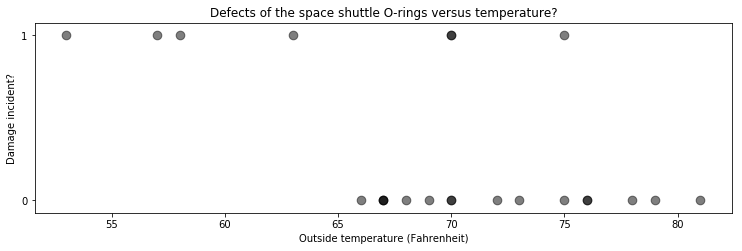

In [29]:
figsize(12.5, 3.5)
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt('data/challenger_data.csv',
                                   skip_header=1,
                                   usecols=[1, 2],
                                   missing_values='NA',
                                   delimiter=",")
# Delete NaN
challenger_data = challenger_data[-np.isnan(challenger_data[:, 1])]

print('Temp (F), O-ring failure?')
print(challenger_data)

plt.scatter(challenger_data[:, 0],
            challenger_data[:, 1],
            s=75, color='k', alpha=0.5)

plt.yticks([0, 1])
plt.ylabel('Damage incident?')
plt.xlabel('Outside temperature (Fahrenheit)')
plt.title('Defects of the space shuttle O-rings versus temperature?')